Mention the appropriate information

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from math import radians, cos, sin, asin, sqrt, asin, atan2, degrees 

#Dataset (Downloadable from "https://storage.googleapis.com/dft-statistics/road-traffic/downloads/data-gov-uk/dft_traffic_counts_aadf.zip")
#Sample points are the randomly choosen line segments throghout UK, which consits of start coordinates (start_x, start_y) and end coordinates (end_x, end_y) of the line segments.

path_to_dataset='D:/traffic_data_analysis/dft_traffic_counts_aadf/dft_traffic_counts_aadf.csv'
path_to_sample_points='D:/traffic_data_analysis/random_sample_points_UK/line_segments.csv'
path_to_save='D:/LPP_data/'
strip_height=5

d=pd.read_csv(F"{path_to_dataset}")
#Filtering the data with latest year traffic
d=d.loc[d.groupby('Count_point_id')['Year'].transform(max) == d['Year']]

#Random sample
s=pd.read_csv(F"{path_to_sample_points}")
s.head(2)


,rand_point_id,id,start_x,start_y,end_x,end_y
0,0,1,-4.056,56.520,-2.756,56.520
1,1,1,-1.128,52.478,0.172,52.478


Necessary functions

In [3]:
def distance(lat1, lat2, lon1, lon2):
     
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)


def get_point_at_distance(lat1, lon1, d, bearing, R=6371):
    """
    lat: initial latitude, in degrees
    lon: initial longitude, in degrees
    d: target distance from initial
    bearing: (true) heading in degrees
    R: optional radius of sphere, defaults to mean radius of earth

    Returns new lat/lon coordinate {d}km from initial, in degrees
    """
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    a = radians(bearing)
    lat2 = asin(sin(lat1) * cos(d/R) + cos(lat1) * sin(d/R) * cos(a))
    lon2 = lon1 + atan2(
        sin(a) * sin(d/R) * cos(lat1),
        cos(d/R) - sin(lat1) * sin(lat2)
    )
    return (degrees(lat2), degrees(lon2),)

Dividing the sample into two parts;
(Important: Run only one of the below two cells to get the portion of the data you want to do the statistical analysis.)
However, one can run the statistical analysis on the whole sample points. Then just ignore the two cells below.

In [4]:
#East-South portion of the samples of UK with longitude <= 54 and latitude >= -3.066
s=s[(s['start_x']>=-3.066) & (s['start_y']<=54) ]
s=s.reset_index()

In [ ]:
#West-North portion of the sample
s=s[(s['start_x']<=-3.066) | (s['start_y']>=54) ]
s=s.reset_index()

Statistical Analysis
(Approximately time taken is 90 sec to run one value of 'k')

In [5]:
#Output dataframe
o=pd.DataFrame(zip([],[],[]),columns=['Traffic','Distance','Probability'])

#Given a dataframe containing 'Latitude', 'Longitude' s, n and k.
#Mention the range of traffic by n and distance by k. 
#Calculating the relative frequency of the traffic count more than n within distance k.
for n in range(1000,100000,1000):
    for k in range(0,90,1):
        count=0
        for i in range(len(s)):
            lt_n, ln_n= get_point_at_distance(s['start_y'][i], s['start_x'][i], strip_height/2, 0)
            lt_s, ln_s= get_point_at_distance(s['start_y'][i], s['start_x'][i], strip_height/2, 180)
            lt_e, ln_e= get_point_at_distance(s['start_y'][i], s['start_x'][i], k, 90)
            if d[(d['Latitude']<=lt_n) & (d['Latitude']>=lt_s) & (d['Longitude']<=ln_e) & (d['Longitude']>=s['start_x'][i]) & (d['All_motor_vehicles']>=n)].empty:
                count=count+1
        o.loc[len(o)] = [n,k,(len(s)-count)/len(s)]
            
o.to_csv(F'{path_to_save}'+F'Statistics_width_{strip_height}.csv')

Visualization of the statistics

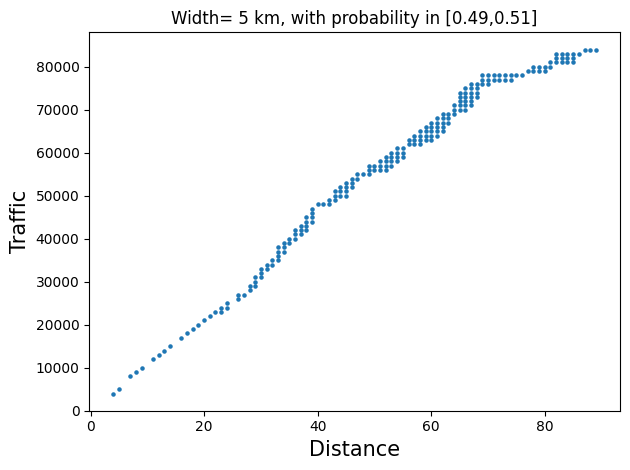

In [6]:
o=pd.read_csv(F'{path_to_save}'+F'Statistics_width_{strip_height}.csv')

x=np.array(list(o[(o['Probability']<=0.51) & (o['Probability']>=0.49)]['Distance']))
y=np.array(list(o[(o['Probability']<=0.51) & (o['Probability']>=0.49)]['Traffic']))
plt.scatter(x,y,s=5)
plt.title(F'Width= {strip_height} km, with probability in [0.49,0.51]')
plt.xlabel('Distance', fontsize=15)
plt.ylabel('Traffic', fontsize=15)
plt.tight_layout()

plt.savefig(F'{path_to_save}'+F'Statistics_figure_width_{strip_height}')